# Support Vector Regression (SVR) με RBF kernel

In [1]:
!pip install -q scikit-learn pandas numpy matplotlib seaborn

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import re

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR


In [3]:
TRAIN_FEATURES = "/content/train_hh_features.csv"
TRAIN_TARGET   = "/content/train_hh_gt.csv"
TRAIN_RATES_GT = "/content/train_rates_gt.csv"
TEST_FEATURES  = "/content/test_hh_features.csv"

In [4]:
X_train = pd.read_csv(TRAIN_FEATURES)
y_train = pd.read_csv(TRAIN_TARGET)
X_test  = pd.read_csv(TEST_FEATURES)

print(X_train.shape, y_train.shape, X_test.shape)

(104234, 88) (104234, 3) (103023, 88)


In [5]:
print(X_train.columns.tolist())
print(y_train.columns.tolist())


['hhid', 'com', 'weight', 'strata', 'utl_exp_ppp17', 'male', 'hsize', 'num_children5', 'num_children10', 'num_children18', 'age', 'owner', 'water', 'toilet', 'sewer', 'elect', 'water_source', 'sanitation_source', 'dweltyp', 'num_adult_female', 'num_adult_male', 'num_elderly', 'employed', 'sworkershh', 'share_secondary', 'educ_max', 'sfworkershh', 'any_nonagric', 'sector1d', 'region1', 'region2', 'region3', 'region4', 'region5', 'region6', 'region7', 'urban', 'consumed100', 'consumed200', 'consumed300', 'consumed400', 'consumed500', 'consumed600', 'consumed700', 'consumed800', 'consumed900', 'consumed1000', 'consumed1100', 'consumed1200', 'consumed1300', 'consumed1400', 'consumed1500', 'consumed1600', 'consumed1700', 'consumed1800', 'consumed1900', 'consumed2000', 'consumed2100', 'consumed2200', 'consumed2300', 'consumed2400', 'consumed2500', 'consumed2600', 'consumed2700', 'consumed2800', 'consumed2900', 'consumed3000', 'consumed3100', 'consumed3200', 'consumed3300', 'consumed3400', 'c

In [6]:
# Section 3: Merge Features με Target

data = X_train.merge(y_train, on="hhid", how="inner")

print("Columns after merge:")
print(data.columns.tolist())

if "survey_id_x" in data.columns and "survey_id_y" in data.columns:
    data["survey_id"] = data["survey_id_x"]
    data = data.drop(columns=["survey_id_x", "survey_id_y"])


survey_id = data["survey_id"]
hhid = data["hhid"]

X = data.drop(columns=["hhid", "survey_id", "cons_ppp17"])
y = np.log1p(data["cons_ppp17"])

print("Final shapes:")
print("X:", X.shape)
print("y:", y.shape)


Columns after merge:
['hhid', 'com', 'weight', 'strata', 'utl_exp_ppp17', 'male', 'hsize', 'num_children5', 'num_children10', 'num_children18', 'age', 'owner', 'water', 'toilet', 'sewer', 'elect', 'water_source', 'sanitation_source', 'dweltyp', 'num_adult_female', 'num_adult_male', 'num_elderly', 'employed', 'sworkershh', 'share_secondary', 'educ_max', 'sfworkershh', 'any_nonagric', 'sector1d', 'region1', 'region2', 'region3', 'region4', 'region5', 'region6', 'region7', 'urban', 'consumed100', 'consumed200', 'consumed300', 'consumed400', 'consumed500', 'consumed600', 'consumed700', 'consumed800', 'consumed900', 'consumed1000', 'consumed1100', 'consumed1200', 'consumed1300', 'consumed1400', 'consumed1500', 'consumed1600', 'consumed1700', 'consumed1800', 'consumed1900', 'consumed2000', 'consumed2100', 'consumed2200', 'consumed2300', 'consumed2400', 'consumed2500', 'consumed2600', 'consumed2700', 'consumed2800', 'consumed2900', 'consumed3000', 'consumed3100', 'consumed3200', 'consumed3300

Section 4 — Preprocessing + SVR Pipeline

In [7]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))


Numeric features: 22
Categorical features: 64


In [8]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [9]:
pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("svr", SVR(kernel="rbf"))
])


Section 5 — Fine-Tuning

In [10]:
BEST_PARAMS = {
    "svr__C": 1,
    "svr__gamma": 0.01,
    "svr__epsilon": 0.01
}

pipeline.set_params(**BEST_PARAMS)

np.random.seed(42)

final_frac = 0.30
final_size = int(final_frac * len(X))

final_idx = np.random.choice(len(X), size=final_size, replace=False)

X_final = X.iloc[final_idx]
y_final = y.iloc[final_idx]

print(f"Final training subset size: {X_final.shape}")

best_model = pipeline

best_model.fit(X_final, y_final)

print("Final SVR model trained on subset")


Final training subset size: (31270, 86)
Final SVR model trained on subset


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred_log = best_model.predict(X_final)
y_true = np.expm1(y_final)
y_pred = np.expm1(y_pred_log)

eps = 1e-9

MAE = mean_absolute_error(y_true, y_pred)

MSE = mean_squared_error(y_true, y_pred)
RMSE = np.sqrt(MSE)

MAPE = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, eps)))

R2 = r2_score(y_true, y_pred)

print("=== Evaluation Metrics (Train Subset) ===")
print(f"MAE  : {MAE:.4f}")
print(f"RMSE : {RMSE:.4f}")
print(f"MAPE : {MAPE:.6f}")
print(f"R²   : {R2:.6f}")


=== Evaluation Metrics (Train Subset) ===
MAE  : 2.5760
RMSE : 5.4775
MAPE : 0.215947
R²   : 0.704284


Γραφήματα

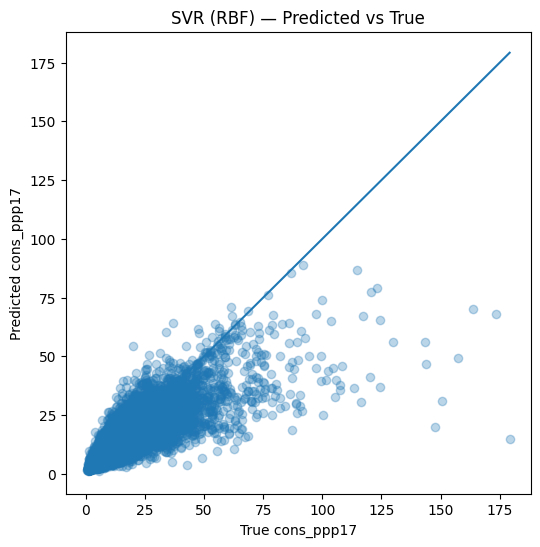

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.3)
mn = min(y_true.min(), y_pred.min())
mx = max(y_true.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx])
plt.xlabel("True cons_ppp17")
plt.ylabel("Predicted cons_ppp17")
plt.title("SVR (RBF) — Predicted vs True")
plt.show()


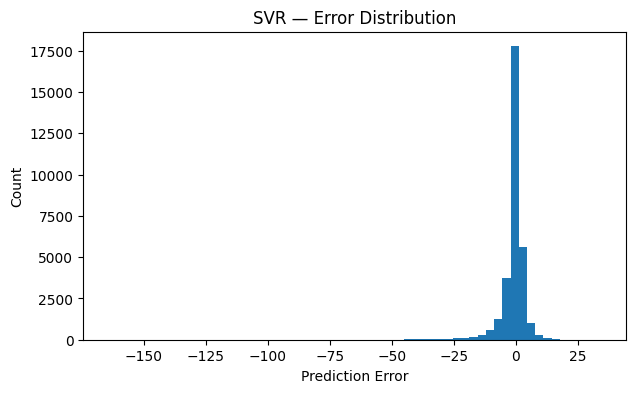

In [14]:
errors = y_pred - y_true

plt.figure(figsize=(7,4))
plt.hist(errors, bins=60)
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.title("SVR — Error Distribution")
plt.show()


Test Data

In [15]:
survey_col = None
for c in ["survey_id", "survey_id_x", "survey_id_y", "survey"]:
    if c in X_test.columns:
        survey_col = c
        break

X_test_meta = X_test[["hhid", survey_col, "weight", "hsize"]].copy()
X_test_meta = X_test_meta.rename(columns={survey_col: "survey_id"})

X_test_feat = X_test.drop(columns=["hhid", survey_col], errors="ignore")
X_test_feat = X_test_feat.reindex(columns=X.columns, fill_value=np.nan)

print("X_test_feat shape:", X_test_feat.shape)


X_test_feat shape: (103023, 86)


In [16]:
test_pred_log = best_model.predict(X_test_feat)
test_pred = np.expm1(test_pred_log)

X_test_meta["cons_pred"] = test_pred


predicted_household_consumption.csv

In [29]:
hh_submission = X_test_meta[["survey_id", "hhid", "cons_pred"]].copy()

hh_submission.columns = ["survey_id", "hhid", "cons_ppp17"]

hh_submission = hh_submission.sort_values(["survey_id", "hhid"])

hh_submission.to_csv(
    "predicted_household_consumption.csv",
    index=False
)

print("predicted_household_consumption.csv updated to correct format")
display(hh_submission.head())

predicted_household_consumption.csv updated to correct format


,survey_id,hhid,cons_ppp17
0,400000,400001,8.509043
1,400000,400002,7.142765
2,400000,400003,7.411387
3,400000,400004,10.507030
4,400000,400005,4.887419


predicted_poverty_distribution.csv

In [30]:
train_rates_gt = pd.read_csv(TRAIN_RATES_GT)

poverty_cols = [c for c in train_rates_gt.columns if c.startswith("pct_hh_below_")]

print("Poverty columns:", poverty_cols)

pred_df = X_test_meta.copy()
pred_df["cons_pred"] = test_pred
pred_df["pop_weight"] = (
    pred_df["weight"].astype(float) *
    pred_df["hsize"].astype(float)
)

poverty_rows = []

for survey_id in pred_df["survey_id"].unique():
    survey_df = pred_df[pred_df["survey_id"] == survey_id]

    denom = survey_df["pop_weight"].sum()
    if denom <= 0:
        continue

    for col in poverty_cols:
        threshold = float(col.replace("pct_hh_below_", ""))

        rate = (
            (survey_df["pop_weight"] *
             (survey_df["cons_pred"] < threshold))
            .sum() / denom
        )

        poverty_rows.append([survey_id, col, rate])

poverty_df = pd.DataFrame(
    poverty_rows,
    columns=["survey_id", "poverty_line", "poverty_rate"]
)

poverty_df.to_csv(
    "predicted_poverty_distribution.csv",
    index=False
)

Poverty columns: ['pct_hh_below_3.17', 'pct_hh_below_3.94', 'pct_hh_below_4.60', 'pct_hh_below_5.26', 'pct_hh_below_5.88', 'pct_hh_below_6.47', 'pct_hh_below_7.06', 'pct_hh_below_7.70', 'pct_hh_below_8.40', 'pct_hh_below_9.13', 'pct_hh_below_9.87', 'pct_hh_below_10.70', 'pct_hh_below_11.62', 'pct_hh_below_12.69', 'pct_hh_below_14.03', 'pct_hh_below_15.64', 'pct_hh_below_17.76', 'pct_hh_below_20.99', 'pct_hh_below_27.37']


In [28]:
assert "poverty_df" in globals(), "poverty_df δεν υπάρχει"

poverty_wide = (
    poverty_df
    .pivot(index="survey_id", columns="poverty_line", values="poverty_rate")
    .reset_index()
)

print("Columns after pivot:", poverty_wide.columns.tolist())

official_columns = [
    "survey_id",
    "pct_hh_below_3.17",
    "pct_hh_below_3.94",
    "pct_hh_below_4.60",
    "pct_hh_below_5.26",
    "pct_hh_below_5.88",
    "pct_hh_below_6.47",
    "pct_hh_below_7.06",
    "pct_hh_below_7.70",
    "pct_hh_below_8.40",
    "pct_hh_below_9.13",
    "pct_hh_below_9.87",
    "pct_hh_below_10.70",
    "pct_hh_below_11.62",
    "pct_hh_below_12.69",
    "pct_hh_below_14.03",
    "pct_hh_below_15.64",
    "pct_hh_below_17.76",
    "pct_hh_below_20.99",
    "pct_hh_below_27.37",
]

assert "survey_id" in poverty_wide.columns, " survey_id εξακολουθεί να λείπει"

missing = [c for c in official_columns if c not in poverty_wide.columns]
if missing:
    raise ValueError(f"Λείπουν οι στήλες: {missing}")

poverty_wide = poverty_wide[official_columns].sort_values("survey_id")

poverty_wide.columns.name = None

print("Final columns:", poverty_wide.columns.tolist())

poverty_wide.to_csv("predicted_poverty_distribution.csv", index=False)

display(poverty_wide.head())


Columns after pivot: ['survey_id', 'pct_hh_below_10.70', 'pct_hh_below_11.62', 'pct_hh_below_12.69', 'pct_hh_below_14.03', 'pct_hh_below_15.64', 'pct_hh_below_17.76', 'pct_hh_below_20.99', 'pct_hh_below_27.37', 'pct_hh_below_3.17', 'pct_hh_below_3.94', 'pct_hh_below_4.60', 'pct_hh_below_5.26', 'pct_hh_below_5.88', 'pct_hh_below_6.47', 'pct_hh_below_7.06', 'pct_hh_below_7.70', 'pct_hh_below_8.40', 'pct_hh_below_9.13', 'pct_hh_below_9.87']
Final columns: ['survey_id', 'pct_hh_below_3.17', 'pct_hh_below_3.94', 'pct_hh_below_4.60', 'pct_hh_below_5.26', 'pct_hh_below_5.88', 'pct_hh_below_6.47', 'pct_hh_below_7.06', 'pct_hh_below_7.70', 'pct_hh_below_8.40', 'pct_hh_below_9.13', 'pct_hh_below_9.87', 'pct_hh_below_10.70', 'pct_hh_below_11.62', 'pct_hh_below_12.69', 'pct_hh_below_14.03', 'pct_hh_below_15.64', 'pct_hh_below_17.76', 'pct_hh_below_20.99', 'pct_hh_below_27.37']


,survey_id,pct_hh_below_3.17,pct_hh_below_3.94,pct_hh_below_4.60,pct_hh_below_5.26,pct_hh_below_5.88,pct_hh_below_6.47,pct_hh_below_7.06,pct_hh_below_7.70,pct_hh_below_8.40,pct_hh_below_9.13,pct_hh_below_9.87,pct_hh_below_10.70,pct_hh_below_11.62,pct_hh_below_12.69,pct_hh_below_14.03,pct_hh_below_15.64,pct_hh_below_17.76,pct_hh_below_20.99,pct_hh_below_27.37
0,400000,0.036697,0.084478,0.136030,0.186548,0.239240,0.288412,0.343037,0.403642,0.468810,0.532553,0.602239,0.662778,0.723786,0.777306,0.828935,0.873954,0.915687,0.951732,0.982273
1,500000,0.025403,0.072035,0.124237,0.178515,0.237482,0.297594,0.354094,0.419762,0.484669,0.547979,0.612954,0.677683,0.734858,0.788177,0.839874,0.880468,0.920908,0.954860,0.984288
2,600000,0.033655,0.078687,0.125757,0.177372,0.230543,0.292781,0.345625,0.411984,0.480560,0.545170,0.608498,0.668375,0.729131,0.786267,0.836948,0.878752,0.916255,0.953968,0.982330


In [31]:
import zipfile

with zipfile.ZipFile("submissionSVR.zip", "w") as z:
    z.write("predicted_household_consumption.csv")
    z.write("predicted_poverty_distribution.csv")
